In [6]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from IPython.core.display import display, HTML
color = sns.color_palette()
%matplotlib inline

In [7]:
attendance_df = pd.read_csv("C://Users/Austin/datasets/NBA/nba_2017_attendance.csv")
endorsement_df = pd.read_csv("C://Users/Austin/datasets/NBA/nba_2017_endorsements.csv")
valuations_df = pd.read_csv("C://Users/Austin/datasets/NBA/nba_2017_team_valuations.csv")
salary_df = pd.read_csv("C://Users/Austin/datasets/NBA/nba_2017_salary.csv")
pie_df = pd.read_csv("C://Users/Austin/datasets/NBA/nba_2017_pie.csv")
plus_minus_df = pd.read_csv("C://Users/Austin/datasets/NBA/nba_2017_real_plus_minus.csv")
br_stats_df = pd.read_csv("C://Users/Austin/datasets/NBA/nba_2017_br.csv")
elo_df = pd.read_csv("C://Users/Austin/datasets/NBA/nba_2017_elo.csv")


In [8]:
plus_minus_df.rename(columns = {'NAME':'PLAYER'}, inplace= True)
plus_minus_df = plus_minus_df.drop(columns=['TEAM','GP'])
player_df = plus_minus_df.merge(pie_df, how="inner", on="PLAYER")

In [9]:
k_means = KMeans(n_clusters=5)
cluster_source = pie_df.loc[:,["W", "NETRTG", "DEFRTG", 'TS%', 'EFG%']]
kmeans = k_means.fit(cluster_source)
pie_df['cluster'] = kmeans.labels_


In [11]:
pbp_2020_df = pd.read_csv("C://Users/Austin/datasets/NBA/NBA-PBP-2019-2020.csv")
fourth_quarter_df = pbp_2020_df[pbp_2020_df['Quarter'] == 4]

In [13]:
clutch_df = fourth_quarter_df[fourth_quarter_df['SecLeft'] <= 120]
super_clutch_df = clutch_df[abs(clutch_df['AwayScore'] - clutch_df['HomeScore']) <= 5]
super_clutch_df = super_clutch_df[super_clutch_df['Shooter'].notna()]
garbagetime_df = clutch_df[abs(clutch_df['AwayScore'] - clutch_df['HomeScore']) >= 12]

In [15]:
shooters = []
for i in super_clutch_df['Shooter'].unique():
    shooters.append(i)
    
clean_df = pd.DataFrame([], columns = ['Player','Team', 'Clutch Attempts', 'Makes', 'Misses'])
print(clean_df.head())

for person in shooters:
    person_df = super_clutch_df[super_clutch_df['Shooter'] == person]
    team = person[-3:]
    try:
        make = int(person_df['ShotOutcome'].value_counts()['make'])
    except:
        make = 0
    try:
        miss = int(person_df['ShotOutcome'].value_counts()['miss'])
    except:
        miss = 0
    attempts = make + miss
    clean_df = clean_df.append({'Player': person,
                                'Team':team,
                                'Clutch Attempts':attempts,
                                'Makes':make,
                                'Misses':miss},
                                 ignore_index = True)    
    

Empty DataFrame
Columns: [Player, Team, Clutch Attempts, Makes, Misses]
Index: []


In [16]:
clean_df['Shot%'] = (clean_df['Makes']/clean_df['Clutch Attempts'])*100

In [17]:
#removing players that took 2 or less shots in this timeframe -- not enough data
clean_df = clean_df[clean_df['Clutch Attempts'] > 4]

In [18]:
clean_df.reset_index(inplace=True)
clean_df

,index,Player,Team,Clutch Attempts,Makes,Misses,Shot%
0,0,K. Lowry - TOR,TOR,25,10,15,40
1,1,J. Hart - NOP,NOP,8,5,3,62.5
2,2,F. VanVleet - TOR,TOR,9,3,6,33.3333
3,3,J. Redick - NOP,NOP,14,5,9,35.7143
4,4,J. Holiday - NOP,NOP,15,6,9,40
...,...,...,...,...,...,...,...
151,255,J. Johnson - MIA,MIA,6,4,2,66.6667
152,259,C. Wood - DET,DET,8,5,3,62.5
153,277,V. Oladipo - IND,IND,12,2,10,16.6667
154,278,J. Clarkson - UTA,UTA,5,2,3,40


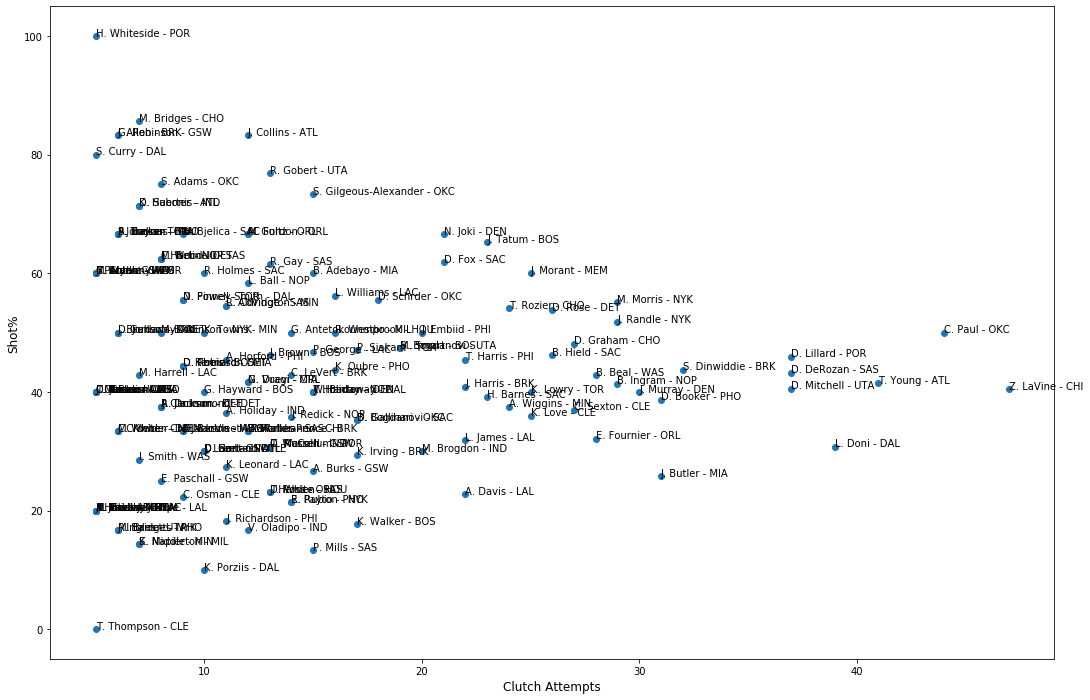

In [21]:
fig, ax = plt.subplots(figsize = (18,12))
ax.scatter(clean_df['Clutch Attempts'], clean_df['Shot%'])
ax.set_xlabel('Clutch Attempts', fontsize=12)
ax.set_ylabel('Shot%', fontsize=12)
for i, txt in enumerate(clean_df['Player']):
    ax.annotate(txt, (clean_df['Clutch Attempts'][i], clean_df['Shot%'][i]))

In [22]:
k_means = KMeans(n_clusters=3)
cluster_source = clean_df.loc[:,['Clutch Attempts','Makes', 'Misses', 'Shot%']]
kmeans = k_means.fit(cluster_source)
clean_df['cluster'] = kmeans.labels_
cluster_1 = clean_df["cluster"] == 0
cluster_2 = clean_df["cluster"] == 1
cluster_3 = clean_df["cluster"] == 2

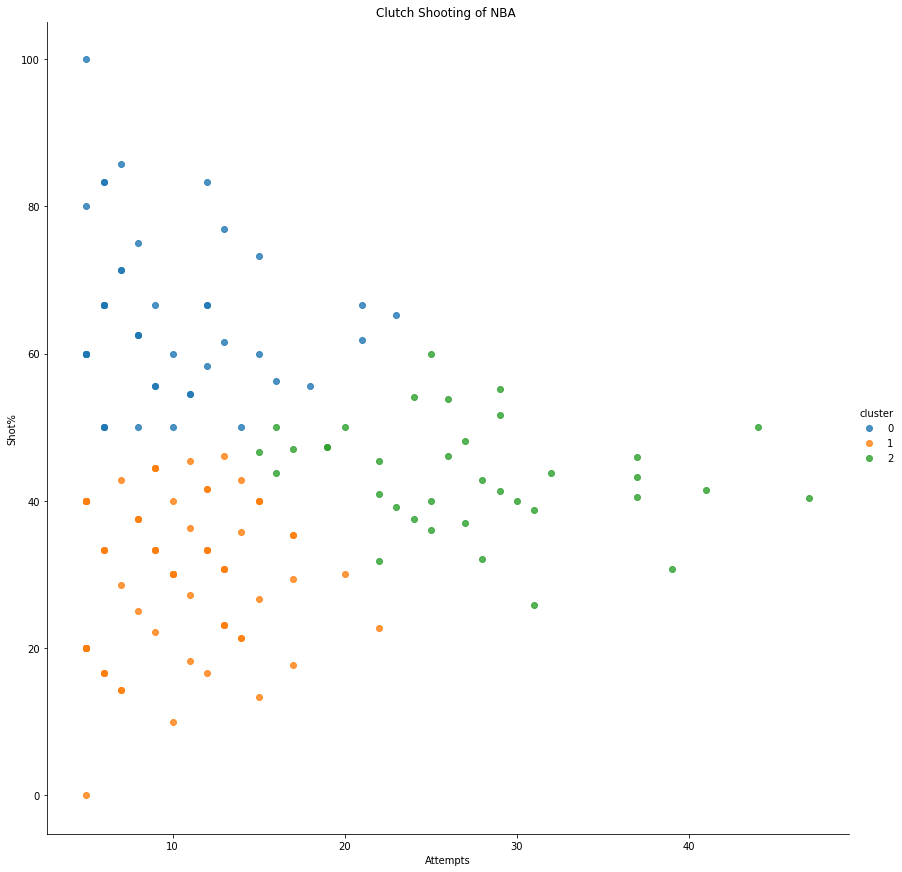

In [23]:
ax = sns.lmplot(x="Clutch Attempts", y="Shot%", data=clean_df, hue="cluster", height=12, fit_reg=False)
ax.set(xlabel='Attempts', ylabel='Shot%', title="Clutch Shooting of NBA ")